# Demo: Solving Least Squares Problems using QR Factorization and Conjugate Gradient Methods in Julia

This Jupyter Notebook demonstrates various techniques for solving least squares problems in Julia, including QR decomposition, sparse QR, conjugate gradient, and preconditioned conjugate gradient methods.


In [ ]:
using LinearAlgebra
using IterativeSolvers
using Plots

## 1. QR Decomposition

In [52]:
A = rand(5, 3)
b = rand(5)

# compute QR
Q, R = qr(A)

# Check that A = QR
@show norm(A - Q*R)

Q

norm(A - Q * R) = 5.530694562324905e-16


5×5 LinearAlgebra.QRCompactWYQ{Float64, Matrix{Float64}, Matrix{Float64}}:
 -0.0631083   0.71032   -0.215069    0.189295   0.639825
 -0.704227    0.376378   0.466356   -0.292086  -0.244133
 -0.187927    0.14681   -0.822929   -0.383574  -0.344657
 -0.53265    -0.202473  -0.222206    0.779858  -0.133172
 -0.425498   -0.539663  -0.0983303  -0.351492   0.628092

In [22]:
# Q is orthogonal
Q'*Q

5×5 Matrix{Float64}:
  1.0          -1.11022e-16  -2.77556e-17   5.55112e-17  -5.55112e-17
 -2.22045e-16   1.0           0.0           0.0           1.11022e-16
 -2.22045e-16   5.55112e-17   1.0           1.11022e-16   1.11022e-16
  1.11022e-16   5.55112e-17   2.22045e-16   1.0           0.0
 -4.16334e-17   1.11022e-16   1.11022e-16  -1.11022e-16   1.0

In [23]:
# R is triangular 
R

3×3 Matrix{Float64}:
 -1.33809  -0.951168  -0.947551
  0.0      -0.910103  -0.740643
  0.0       0.0       -0.497609

## 2. QR Decomposition of a Rank-Deficient Matrix

In [24]:
A_rank_deficient = hcat(A, A[:, 1])  # Adding a linearly dependent column

Q_rd, R_rd = qr(A_rank_deficient)

# Check that A_rank_deficient = Q_rd * R_rd
norm(A_rank_deficient - Q_rd*R_rd)

1.3710242980056706e-15

In [25]:
# R has extra zeros in this case 
R_rd

4×4 Matrix{Float64}:
 -1.33809  -0.951168  -0.947551  -1.33809
  0.0      -0.910103  -0.740643   3.33067e-16
  0.0       0.0       -0.497609   2.02762e-16
  0.0       0.0        0.0        1.09741e-16

## 3. Using QR to Solve Least Squares (Explicitly and Using Backslash)

In [29]:
# this works in previous Julia versions but gives an error now due to dimension mismatch b/c R is not rectangular
# x_qr = R \ (Q' * b)

x_backslash = A \ b

# Compare the solutions
norm(x_qr - x_backslash)

DimensionMismatch: DimensionMismatch: dimensions must match: a has dims (Base.OneTo(4),), b has dims (Base.OneTo(3),), mismatch at 1

In [30]:
Q

5×5 LinearAlgebra.QRCompactWYQ{Float64, Matrix{Float64}, Matrix{Float64}}:
 -0.69381     0.604012   0.160189  -0.161626   0.319396
 -0.394763   -0.15396   -0.769923  -0.328235  -0.346323
 -0.304882   -0.355845  -0.282783   0.675397   0.494261
 -0.510538   -0.379703   0.506778   0.185195  -0.551412
 -0.0958561  -0.583666   0.211586  -0.612927   0.479267

In [31]:
R

3×3 Matrix{Float64}:
 -1.33809  -0.951168  -0.947551
  0.0      -0.910103  -0.740643
  0.0       0.0       -0.497609

In [28]:
Q*R

5×3 Matrix{Float64}:
 0.928383  0.110217  0.130351
 0.52823   0.515605  0.871208
 0.407961  0.61385   0.693161
 0.683148  0.831177  0.512808
 0.128264  0.622371  0.417829

## 4. QR Works Better than Pseudoinverse on an Ill-Conditioned Matrix

In [32]:
A_ill_conditioned = [1 1; 1 1+1e-14]
b = [1; 2]

x_qr_ill = A_ill_conditioned \ b

x_pinv_ill = pinv(A_ill_conditioned) * b

# Compare the solutions
@show norm(A_ill_conditioned * x_qr_ill - b)
@show norm(A_ill_conditioned * x_pinv_ill - b)

norm(A_ill_conditioned * x_qr_ill - b) = 0.0
norm(A_ill_conditioned * x_pinv_ill - b) = 0.015661332786963203


0.015661332786963203

In [33]:
x_qr_ill

2-element Vector{Float64}:
 -1.0007999171934336e14
  1.0007999171934436e14

In [34]:
x_pinv_ill

2-element Vector{Float64}:
 -9.840953950786555e13
  9.840953950786656e13

## 5. Sparse QR and Fill-in Depending on Permutation

In [70]:
using SparseArrays

A_sparse = sprand(10, 10, 0.2)

qr(A_sparse)

SuiteSparse.SPQR.QRSparse{Float64, Int64}
Q factor:
10×10 SuiteSparse.SPQR.QRSparseQ{Float64, Int64}:
 1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0
R factor:
10×10 SparseMatrixCSC{Float64, Int64} with 25 stored entries:
 0.00977181  0.686932  0.302995   ⋅        …   ⋅         ⋅           ⋅ 
  ⋅          0.421578  0.169526  0.417967     0.939032   ⋅           ⋅ 
  ⋅           ⋅        0.911152   ⋅            ⋅         ⋅           ⋅ 
  ⋅           ⋅         ⋅        0.213006     0.681058  0.0849109    ⋅ 
  ⋅           ⋅         ⋅         ⋅   

In [69]:
# now try a different ordering and observe different results 
A_dense = Array(A_sparse)
qr(A_dense)

LinearAlgebra.QRCompactWY{Float64, Matrix{Float64}, Matrix{Float64}}
Q factor:
10×10 LinearAlgebra.QRCompactWYQ{Float64, Matrix{Float64}, Matrix{Float64}}:
  0.0       -3.8311e-16  0.0   0.0  …  -7.38774e-19   3.08187e-19
  0.0        0.0         0.0   0.0      1.46746e-17   3.83079e-16
  0.0        0.0         1.0   0.0      0.0           0.0
 -0.992966  -0.0288216   0.0   0.0     -0.0422044    -0.101171
  0.0        0.0         0.0   0.0      2.21093e-16  -2.05355e-17
  0.0        0.0         0.0   0.0  …   0.922915     -0.385004
 -0.1184     0.241714    0.0   0.0      0.353949      0.848473
  0.0        0.0         0.0   0.0     -0.114731     -0.275028
  0.0        0.0         0.0  -1.0      0.0           1.46523e-17
  0.0       -0.96992     0.0   0.0      0.0894618     0.214454
R factor:
10×10 Matrix{Float64}:
 -0.512537  -0.987246  0.0   0.0       …   0.0          0.0         0.0  0.0
  0.0       -0.483588  0.0   0.0           0.0          0.0         0.0  0.0
  0.0        0.0    

In [80]:
nnz(qr(A_sparse).R)

25

In [82]:
nnz(sparse(qr(A_dense).R))

15

# Conjugate gradient method

In [38]:
# solve least squares min \|Ax - b\|^2 with cg by forming normal equation
A = rand(4, 4)
b = rand(4)
AtA = A' * A
Atb = A' * b

x_cg, hist_cg = cg(AtA, Atb, log=true)

println("Conjugate Gradient solution:")
println(x_cg)
println("solves least squares problem and matches QR solution")
println(x_cg - A \ b)

Conjugate Gradient solution:
[0.9503688890388536, -0.1779324973207363, -1.186132214875607, 3.07503873935487]
solves least squares problem and matches QR solution
[5.193623309196482e-13, 9.413581025796702e-13, 8.040235144335384e-13, 4.369837824924616e-13]


In [46]:
function conjugate_gradient(A, b, x, max_iter=50)
    # Initialize variables
    r = b - A*x
    p = r
    r_norm_sq = dot(r, r)
    iterates = zeros(length(x), max_iter)
    for i in 1:max_iter
        Ap = A*p
        alpha = r_norm_sq / dot(p, Ap)
        x = x + alpha*p
        r = r - alpha*Ap
        r_norm_sq_new = dot(r, r)
        beta = r_norm_sq_new / r_norm_sq
        p = r + beta*p
        r_norm_sq = r_norm_sq_new
        iterates[:,i] = x
    end
    return x, iterates
end

conjugate_gradient (generic function with 2 methods)

# CG convergence rate depends on condition number

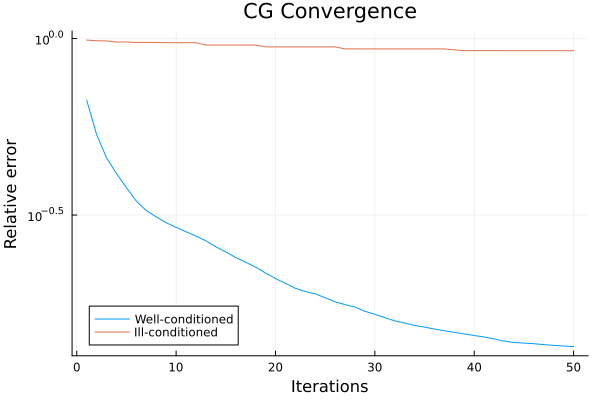

In [48]:
n = 100
A_well = randn(n, n)
A_well = A_well * A_well'
xtrue = rand(n) 
b_well = A_well * xtrue
# create ill conditioned problem with same solution 
A_ill = Diagonal([10.0^(-i) for i in 1:n]) * A_well * Diagonal([10.0^(-i) for i in 1:n])
b_ill = A_ill * xtrue

# initialize in the same place
x0 = zeros(n)
max_iter = 50

_, iterates_well = conjugate_gradient(A_well, b_well, x0, max_iter)
_, iterates_ill = conjugate_gradient(A_ill, b_ill, x0, max_iter)

nxt = norm(xtrue)
error_well = [norm(x - xtrue)/nxt for x in eachcol(iterates_well)]
error_ill = [norm(x - xtrue)/nxt for x in eachcol(iterates_ill)]

plot(1:max_iter, error_well, label="Well-conditioned", yscale=:log10, xlabel="Iterations", ylabel="Relative error", title="CG Convergence")
plot!(1:max_iter, error_ill, label="Ill-conditioned")

# Preconditioned CG has improved convergence rate

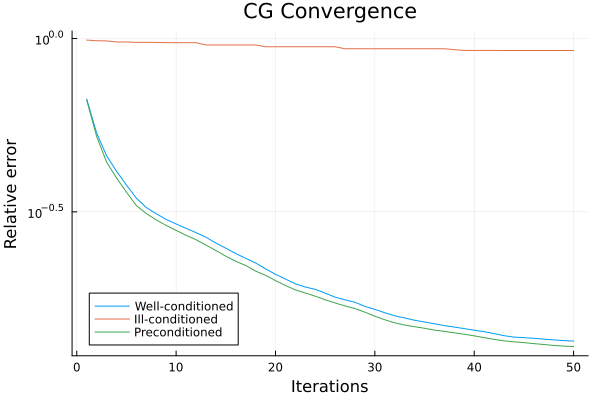

In [51]:
M_invhalf = Diagonal(sqrt.(1.0 ./ diag(A_ill)))  # Jacobi preconditioner
A_precond = M_invhalf * A_ill * M_invhalf
b_precond = A_precond * xtrue

_, iterates_precond = conjugate_gradient(A_precond, b_precond, x0, max_iter)
error_precond = [norm(x - xtrue)/nxt for x in eachcol(iterates_precond)]

plot(1:max_iter, error_well, label="Well-conditioned", yscale=:log10, xlabel="Iterations", ylabel="Relative error", title="CG Convergence")
plot!(1:max_iter, error_ill, label="Ill-conditioned")
plot!(1:max_iter, error_precond, label="Preconditioned")